In [1]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [9]:
PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban.pkl'
NEW_PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban_weather.pkl'

In [10]:
hopkins_confirmed = pd.read_pickle(NEW_PICKLE_PATH)

##### Discard all locations where count < 20, add interval weather data

In [9]:
coords = set(hopkins_confirmed.index.get_level_values(0).tolist())
discarded = 0
for coord in coords:
    cases = hopkins_confirmed.loc[coord]['Max_Cases']['data']
    if cases < 20:
        discarded += 1
        country = hopkins_confirmed.loc[coord]['Country_Region']['data']
        province = hopkins_confirmed.loc[coord]['Province_State']['data']
        print('Dropped {0}, {1}, {2} with {3} cases'.format(discarded, province, country, cases))
        hopkins_confirmed.drop(coord, level=0, inplace=True)
        continue
    try:
        last_rel_date = hopkins_confirmed.loc[coord]['last relevant date']['data']
        five_prcnt_date = hopkins_confirmed.loc[coord]['5%_Date']['data']

        five_prct_column = hopkins_confirmed.columns.get_loc(five_prcnt_date)
        last_rel_column = hopkins_confirmed.columns.get_loc(last_rel_date)
        interval = hopkins_confirmed[hopkins_confirmed.columns[five_prct_column:last_rel_column]]

        hopkins_confirmed.loc[coord, 'avg_interval_tmp']['data'] = interval.loc[coord].loc['avg_d_tmp'].mean()
        hopkins_confirmed.loc[coord, 'avg_interval_RH']['data'] = interval.loc[coord].loc['avg_d_RH'].mean()
    except KeyError as e:
        print('key error, {0}'.format(coord))

Dropped 1, Missouri, US with 0.0 cases
Dropped 2, Missouri, US with 1.0 cases
Dropped 3, Missouri, US with 4.0 cases
Dropped 4, Missouri, US with 2.0 cases
Dropped 5, Oregon, US with 3.0 cases
Dropped 6, Oregon, US with 8.0 cases
Dropped 7, Oregon, US with 4.0 cases
Dropped 8, Grand Princess, Canada with 13.0 cases
Dropped 9, Michigan, US with 2.0 cases
Dropped 10, Maine, US with 13.0 cases
Dropped 11, Wisconsin, US with 1.0 cases
Dropped 12, Kentucky, US with 1.0 cases
Dropped 13, Georgia, US with 4.0 cases
Dropped 14, Arkansas, US with 17.0 cases
Dropped 15, Ohio, US with 4.0 cases
Dropped 16, North Carolina, US with 2.0 cases
Dropped 17, North Carolina, US with 7.0 cases
Dropped 18, Nevada, US with 11.0 cases
Dropped 19, New Mexico, US with 0.0 cases
Dropped 20, Utah, US with 13.0 cases
Dropped 21, Wisconsin, US with 4.0 cases
Dropped 22, Wisconsin, US with 2.0 cases
Dropped 23, Wisconsin, US with 3.0 cases
Dropped 24, Texas, US with 4.0 cases
Dropped 25, Texas, US with 0.0 cases
Dr

Dropped 203, Pennsylvania, US with 9.0 cases
Dropped 204, Pennsylvania, US with 5.0 cases
Dropped 205, Pennsylvania, US with 5.0 cases
Dropped 206, Pennsylvania, US with 1.0 cases
Dropped 207, Idaho, US with 0.0 cases
Dropped 208, Hawaii, US with 18.0 cases
Dropped 209, Utah, US with 1.0 cases
Dropped 210, Missouri, US with 1.0 cases
Dropped 211, Texas, US with 4.0 cases
Dropped 212, Texas, US with 3.0 cases
Dropped 213, Texas, US with 3.0 cases
Dropped 214, Texas, US with 5.0 cases
Dropped 215, nan, Western Sahara with 4.0 cases
Dropped 216, Massachusetts, US with 0.0 cases
Dropped 217, Iowa, US with 0.0 cases
Dropped 218, Iowa, US with 1.0 cases
Dropped 219, Iowa, US with 0.0 cases
Dropped 220, Iowa, US with 1.0 cases
Dropped 221, Iowa, US with 0.0 cases
Dropped 222, Iowa, US with 0.0 cases
Dropped 223, Montana, US with 0.0 cases
Dropped 224, Washington, US with 2.0 cases
Dropped 225, Wisconsin, US with 0.0 cases
Dropped 226, Wisconsin, US with 0.0 cases
Dropped 227, Wisconsin, US wi

Dropped 605, Iowa, US with 1.0 cases
Dropped 606, North Dakota, US with 0.0 cases
Dropped 607, Montana, US with 3.0 cases
Dropped 608, Texas, US with 0.0 cases
Dropped 609, Texas, US with 0.0 cases
Dropped 610, Texas, US with 0.0 cases
Dropped 611, Texas, US with 2.0 cases
Dropped 612, Montana, US with 0.0 cases
Dropped 613, West Virginia, US with 2.0 cases
Dropped 614, Virginia, US with 14.0 cases
Dropped 615, West Virginia, US with 0.0 cases
Dropped 616, West Virginia, US with 3.0 cases
Dropped 617, West Virginia, US with 4.0 cases
Dropped 618, Maryland, US with 7.0 cases
Dropped 619, Pennsylvania, US with 1.0 cases
Dropped 620, South Dakota, US with 0.0 cases
Dropped 621, South Dakota, US with 1.0 cases
Dropped 622, nan, East Timor with 1.0 cases
Dropped 623, Minnesota, US with 1.0 cases
Dropped 624, Indiana, US with 8.0 cases
Dropped 625, Indiana, US with 14.0 cases
Dropped 626, Indiana, US with 11.0 cases
Dropped 627, Indiana, US with 6.0 cases
Dropped 628, Indiana, US with 9.0 ca

Dropped 804, Utah, US with 2.0 cases
Dropped 805, Utah, US with 0.0 cases
Dropped 806, nan, Fiji with 15.0 cases
Dropped 807, nan, Equatorial Guinea with 16.0 cases
Dropped 808, Louisiana, US with 11.0 cases
Dropped 809, Texas, US with 0.0 cases
Dropped 810, Louisiana, US with 7.0 cases
Dropped 811, Virginia, US with 14.0 cases
Dropped 812, Kansas, US with 8.0 cases
Dropped 813, Kansas, US with 9.0 cases
Dropped 814, Kansas, US with 1.0 cases
Dropped 815, Kansas, US with 0.0 cases
Dropped 816, Kansas, US with 0.0 cases
Dropped 817, Kansas, US with 3.0 cases
Dropped 818, Washington, US with 5.0 cases
Dropped 819, Washington, US with 1.0 cases
Dropped 820, Idaho, US with 2.0 cases
Dropped 821, South Dakota, US with 2.0 cases
Dropped 822, South Dakota, US with 0.0 cases
Dropped 823, Kansas, US with 0.0 cases
Dropped 824, Kansas, US with 0.0 cases
Dropped 825, Kansas, US with 0.0 cases
Dropped 826, Kansas, US with 0.0 cases
Dropped 827, South Dakota, US with 3.0 cases
Dropped 828, South Da

Dropped 1008, Illinois, US with 2.0 cases
Dropped 1009, Montana, US with 1.0 cases
Dropped 1010, Montana, US with 11.0 cases
Dropped 1011, nan, Zimbabwe with 11.0 cases
Dropped 1012, Tennessee, US with 6.0 cases
Dropped 1013, Tennessee, US with 5.0 cases
Dropped 1014, Arkansas, US with 1.0 cases
Dropped 1015, Arkansas, US with 1.0 cases
Dropped 1016, Arkansas, US with 1.0 cases
Dropped 1017, Oregon, US with 2.0 cases
Dropped 1018, Wyoming, US with 5.0 cases
Dropped 1019, Utah, US with 2.0 cases
Dropped 1020, Utah, US with 1.0 cases
Dropped 1021, Minnesota, US with 2.0 cases
Dropped 1022, Minnesota, US with 0.0 cases
Dropped 1023, Illinois, US with 0.0 cases
Dropped 1024, Texas, US with 2.0 cases
Dropped 1025, Kansas, US with 0.0 cases
Dropped 1026, Kansas, US with 2.0 cases
Dropped 1027, Kansas, US with 1.0 cases
Dropped 1028, Kansas, US with 4.0 cases
Dropped 1029, Oregon, US with 2.0 cases
Dropped 1030, Vermont, US with 1.0 cases
Dropped 1031, Tennessee, US with 3.0 cases
Dropped 103

Dropped 1206, New York, US with 8.0 cases
Dropped 1207, New York, US with 4.0 cases
Dropped 1208, New York, US with 16.0 cases
Dropped 1209, New York, US with 10.0 cases
Dropped 1210, New York, US with 14.0 cases
Dropped 1211, North Carolina, US with 3.0 cases
Dropped 1212, Tennessee, US with 1.0 cases
Dropped 1213, Tennessee, US with 18.0 cases
Dropped 1214, Tennessee, US with 3.0 cases
Dropped 1215, Tennessee, US with 16.0 cases
Dropped 1216, Virginia, US with 1.0 cases
Dropped 1217, Virginia, US with 0.0 cases
Dropped 1218, Virginia, US with 1.0 cases
Dropped 1219, Illinois, US with 0.0 cases
Dropped 1220, Idaho, US with 0.0 cases
Dropped 1221, Utah, US with 0.0 cases
Dropped 1222, California, US with 0.0 cases
Dropped 1223, Texas, US with 9.0 cases
Dropped 1224, Texas, US with 0.0 cases
Dropped 1225, Texas, US with 1.0 cases
Dropped 1226, Texas, US with 0.0 cases
Dropped 1227, Texas, US with 0.0 cases
Dropped 1228, Texas, US with 0.0 cases
Dropped 1229, Texas, US with 0.0 cases
Dro

Dropped 1402, Virginia, US with 4.0 cases
Dropped 1403, Montana, US with 0.0 cases
Dropped 1404, Minnesota, US with 3.0 cases
Dropped 1405, Arkansas, US with 13.0 cases
Dropped 1406, Michigan, US with 4.0 cases
Dropped 1407, Minnesota, US with 8.0 cases
Dropped 1408, Minnesota, US with 4.0 cases
Dropped 1409, New Mexico, US with 4.0 cases
Dropped 1410, Illinois, US with 2.0 cases
Dropped 1411, Illinois, US with 1.0 cases
Dropped 1412, Illinois, US with 1.0 cases
Dropped 1413, Illinois, US with 14.0 cases
Dropped 1414, Illinois, US with 6.0 cases
Dropped 1415, Illinois, US with 14.0 cases
Dropped 1416, California, US with 11.0 cases
Dropped 1417, North Dakota, US with 3.0 cases
Dropped 1418, North Dakota, US with 0.0 cases
Dropped 1419, South Dakota, US with 6.0 cases
Dropped 1420, Iowa, US with 0.0 cases
Dropped 1421, Iowa, US with 1.0 cases
Dropped 1422, Iowa, US with 0.0 cases
Dropped 1423, Minnesota, US with 4.0 cases
Dropped 1424, South Dakota, US with 1.0 cases
Dropped 1425, Texas

Dropped 1598, South Dakota, US with 0.0 cases
Dropped 1599, South Dakota, US with 0.0 cases
Dropped 1600, South Dakota, US with 0.0 cases
Dropped 1601, Idaho, US with 0.0 cases
Dropped 1602, Illinois, US with 9.0 cases
Dropped 1603, Illinois, US with 11.0 cases
Dropped 1604, Illinois, US with 0.0 cases
Dropped 1605, Illinois, US with 7.0 cases
Dropped 1606, Idaho, US with 5.0 cases
Dropped 1607, Montana, US with 0.0 cases
Dropped 1608, Missouri, US with 1.0 cases
Dropped 1609, Virginia, US with 3.0 cases
Dropped 1610, Maryland, US with 3.0 cases
Dropped 1611, Maryland, US with 8.0 cases
Dropped 1612, Missouri, US with 7.0 cases
Dropped 1613, Missouri, US with 0.0 cases
Dropped 1614, Montana, US with 0.0 cases
Dropped 1615, Oklahoma, US with 19.0 cases
Dropped 1616, Oklahoma, US with 10.0 cases
Dropped 1617, Oklahoma, US with 0.0 cases
Dropped 1618, Mississippi, US with 5.0 cases
Dropped 1619, Mississippi, US with 10.0 cases
Dropped 1620, Mississippi, US with 1.0 cases
Dropped 1621, Mis

Dropped 1791, Kentucky, US with 1.0 cases
Dropped 1792, Kentucky, US with 1.0 cases
Dropped 1793, West Virginia, US with 0.0 cases
Dropped 1794, Kentucky, US with 2.0 cases
Dropped 1795, Kentucky, US with 1.0 cases
Dropped 1796, Oregon, US with 1.0 cases
Dropped 1797, Colorado, US with 1.0 cases
Dropped 1798, Georgia, US with 4.0 cases
Dropped 1799, Georgia, US with 3.0 cases
Dropped 1800, Georgia, US with 3.0 cases
Dropped 1801, Georgia, US with 1.0 cases
Dropped 1802, Georgia, US with 8.0 cases
Dropped 1803, Georgia, US with 0.0 cases
Dropped 1804, Georgia, US with 6.0 cases
Dropped 1805, Georgia, US with 1.0 cases
Dropped 1806, Nebraska, US with 0.0 cases
Dropped 1807, Nebraska, US with 0.0 cases
Dropped 1808, Nebraska, US with 1.0 cases
Dropped 1809, Mississippi, US with 5.0 cases
Dropped 1810, Nebraska, US with 1.0 cases
Dropped 1811, Nebraska, US with 1.0 cases
Dropped 1812, Mississippi, US with 3.0 cases
Dropped 1813, Missouri, US with 17.0 cases
Dropped 1814, Oklahoma, US with 

Dropped 1988, Nebraska, US with 6.0 cases
Dropped 1989, Minnesota, US with 0.0 cases
Dropped 1990, Minnesota, US with 13.0 cases
Dropped 1991, nan, Eswatini with 10.0 cases
Dropped 1992, New Hampshire, US with 1.0 cases
Dropped 1993, Vermont, US with 0.0 cases
Dropped 1994, Illinois, US with 0.0 cases
Dropped 1995, Illinois, US with 2.0 cases
Dropped 1996, Illinois, US with 11.0 cases
Dropped 1997, Illinois, US with 3.0 cases
Dropped 1998, Kentucky, US with 3.0 cases
Dropped 1999, nan, Nicaragua with 6.0 cases
Dropped 2000, Virginia, US with 3.0 cases
Dropped 2001, New Hampshire, US with 6.0 cases
Dropped 2002, Kentucky, US with 0.0 cases
Dropped 2003, North Carolina, US with 13.0 cases
Dropped 2004, North Carolina, US with 1.0 cases
Dropped 2005, North Carolina, US with 5.0 cases
Dropped 2006, New Mexico, US with 0.0 cases
Dropped 2007, New Mexico, US with 0.0 cases
Dropped 2008, California, US with 0.0 cases
Dropped 2009, nan, Laos with 14.0 cases
Dropped 2010, Wisconsin, US with 4.0

Dropped 2186, Alaska, US with 0.0 cases
Dropped 2187, Ohio, US with 1.0 cases
Dropped 2188, Ohio, US with 0.0 cases
Dropped 2189, Iowa, US with 6.0 cases
Dropped 2190, Iowa, US with 5.0 cases
Dropped 2191, Iowa, US with 1.0 cases
Dropped 2192, Iowa, US with 5.0 cases
Dropped 2193, Iowa, US with 3.0 cases
Dropped 2194, Oklahoma, US with 3.0 cases
Dropped 2195, Washington, US with 1.0 cases
Dropped 2196, Washington, US with 16.0 cases
Dropped 2197, Nebraska, US with 2.0 cases
Dropped 2198, nan, Maldives with 19.0 cases
Dropped 2199, Wisconsin, US with 1.0 cases
Dropped 2200, Wisconsin, US with 1.0 cases
Dropped 2201, Wisconsin, US with 3.0 cases
Dropped 2202, Wisconsin, US with 0.0 cases
Dropped 2203, Virginia, US with 1.0 cases
Dropped 2204, Wisconsin, US with 2.0 cases
Dropped 2205, Texas, US with 0.0 cases
Dropped 2206, Texas, US with 0.0 cases
Dropped 2207, Oklahoma, US with 6.0 cases
Dropped 2208, Oklahoma, US with 0.0 cases
Dropped 2209, Iowa, US with 1.0 cases
Dropped 2210, Montan

In [13]:
hopkins_confirmed.to_pickle(NEW_PICKLE_PATH)

In [11]:
hopkins_confirmed.describe()

,GDP,Urbanization,avg_m_tmp,avg_m_RH,avg_m_precip,avg_m_wind,Max_Cases,first_7,avg_interval_tmp,avg_interval_RH,...,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1063.000000,1070.000000,1070.000000,...,5295.000000,5308.000000,5322.000000,5336.000000,5336.000000,5328.000000,5320.000000,5331.000000,5327.000000,5331.000000
mean,52102.320042,74.298066,9.428750,70.922285,1.788514,11.821473,1686.908411,2.956743,12.753437,70.019905,...,180.928716,194.286890,214.074301,230.367822,250.538253,272.385893,298.439432,317.408923,336.277528,357.665864
std,21063.174970,14.606890,7.587477,9.037325,1.682517,3.680288,14944.506938,1.775053,7.341610,10.104754,...,3067.974341,3365.232865,3733.095866,4097.744440,4518.005728,4970.220197,5494.354993,5883.691669,6295.815448,6725.900356
min,396.000000,14.338000,-16.824675,11.831169,0.000000,3.007246,20.000000,0.000000,-9.926087,8.444444,...,-13.200000,-12.600000,-12.900000,-14.700000,-18.700000,-18.100000,-13.800000,-10.200000,-8.700000,-10.300000
25%,46609.000000,66.300000,3.945685,66.922078,0.032922,9.324675,36.250000,1.707143,6.865476,66.542857,...,6.350000,5.500000,6.100000,5.300000,4.300000,4.475000,4.500000,5.000000,5.200000,7.000000
50%,55172.000000,75.100000,8.482468,72.571429,1.601016,11.419895,86.500000,2.666667,12.008036,71.666667,...,16.000000,14.100000,14.000000,13.900000,15.000000,15.800000,14.995000,15.100000,16.800000,18.800000
75%,61594.000000,86.200000,13.866234,76.493506,2.681818,14.035146,306.750000,4.000000,17.847756,76.250940,...,51.000000,47.000000,59.000000,58.000000,54.000000,54.000000,60.000000,64.000000,60.000000,64.000000
max,200277.000000,100.000000,32.323377,88.608696,7.818052,29.774026,396223.000000,11.000000,35.100000,94.000000,...,140909.000000,161837.000000,188172.000000,213372.000000,243616.000000,275586.000000,308850.000000,337072.000000,366667.000000,396223.000000


###### CORRELATIONS AND SCATTER PLOTS PER GF


Inetrval temp correaltion Pearson
GF_Q3              0.053312
GF_Q2              0.025432
first_7           -0.025615
GF_Q1             -0.026928
avg_interval_RH   -0.048916
dtype: float64

Inetrval temp correaltion Spearman
GF_Q3              0.062942
GF_Q2              0.020974
avg_interval_RH    0.018113
GF_Q1             -0.012499
first_7           -0.034133
dtype: float64


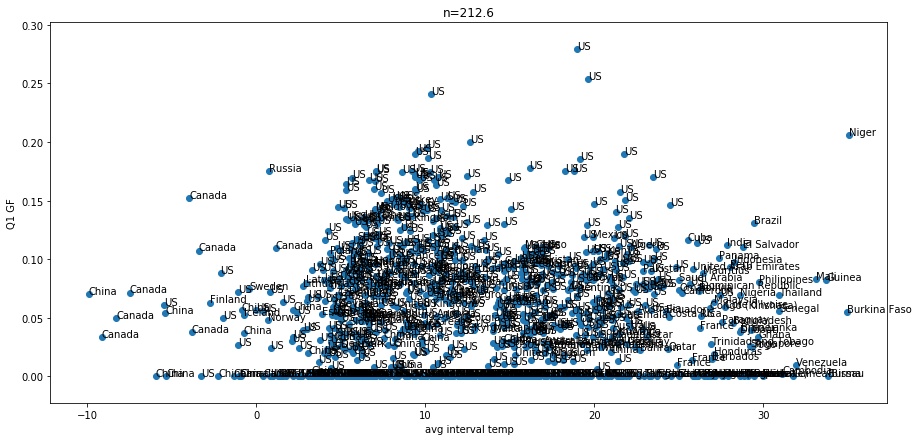

In [34]:
TMP_RATE = 1
RH_RATE = 1

confs1 = hopkins_confirmed[['Country_Region', 'avg_interval_tmp',\
                            'avg_interval_RH', 'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']].dropna()
confs1['avg_interval_tmp'] = confs1['avg_interval_tmp'] * TMP_RATE
confs1['avg_interval_RH'] = confs1['avg_interval_RH'] * RH_RATE

conf_corrs_p1 = confs1.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p1 = conf_corrs_p1[conf_corrs_p1 != 1]
_ = conf_corrs_p1.drop_duplicates()
print('\nInetrval temp correaltion Pearson')
print(conf_corrs_p1['avg_interval_tmp'])

conf_corrs_s1 = confs1.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s1 = conf_corrs_s1[conf_corrs_s1 != 1]
_ = conf_corrs_s1.drop_duplicates()
print('\nInetrval temp correaltion Spearman')
print(conf_corrs_s1['avg_interval_tmp'])

gf_q1_1 = confs1['GF_Q1'].loc[:,'data'].values.tolist()
avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

fig, axes = plt.subplots(figsize=(15, 7))
_ = axes.scatter(avg_int_tmp1, gf_q1_1)
n = len(confs1) / 5 # five entries for each index

_ = axes.set_xlabel('avg interval temp')
_ = axes.set_ylabel('Q1 GF')
_ = axes.set_title('n={0}'.format(n))

countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()

for i, txt in enumerate(countries1):
    _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))


Significant correlations with p-values:

In [17]:
corr_1 = stats.pearsonr(gf_q1_1, avg_int_tmp1)
print('GF_Q1 vs avg_interval_tmp correaltion Pearson: {0}, p-value: {1}'.format(corr_1[0], corr_1[1]))

corr_1 = stats.spearmanr(gf_q1_1, avg_int_tmp1)
print('GF_Q1 vs avg_interval_tmp correaltion Spearman: {0}, p-value: {1}'.format(corr_1[0], corr_1[1]))


GF_Q1 vs avg_interval_tmp correaltion Pearson: -0.015010554817148464, p-value: 0.6238071622938999
GF_Q1 vs avg_interval_tmp correaltion Spearman: -0.009339651349389706, p-value: 0.7602461709810644


###### Correlations of case studies


Inetrval temp correaltion Pearson
first_7           -0.092119
GF_Q3             -0.296945
GF_Q2             -0.301468
avg_interval_RH   -0.361063
GF_Q1             -0.419656
dtype: float64

Inetrval temp correaltion Spearman
first_7           -0.139169
avg_interval_RH   -0.182595
GF_Q2             -0.307350
GF_Q3             -0.354530
GF_Q1             -0.436023
dtype: float64


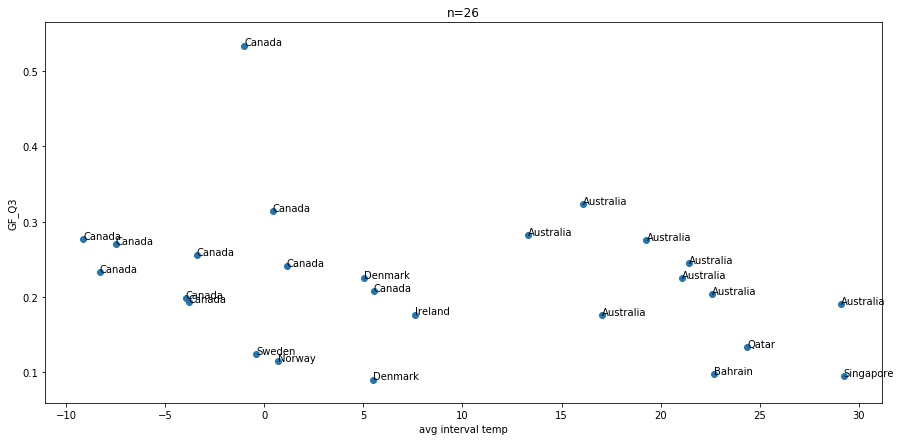

In [35]:
cold = ['Sweden', 'Norway', 'Canada', 'Ireland', 'Denmark']
hot = ['Australia', 'Taiwan*', 'Singapore', 'Qatar', 'Bahrain']

confs2 = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(hot + cold)]\
        [['Country_Region', 'avg_interval_tmp', 'avg_interval_RH', 'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']]


conf_corrs_p2 = confs2.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p2 = conf_corrs_p2[conf_corrs_p2 != 1]
_ = conf_corrs_p2.drop_duplicates()
print('\nInetrval temp correaltion Pearson')
print(conf_corrs_p2['avg_interval_tmp'])

conf_corrs_s2 = confs2.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s2 = conf_corrs_s2[conf_corrs_s2 != 1]
_ = conf_corrs_s2.drop_duplicates()
print('\nInetrval temp correaltion Spearman')
print(conf_corrs_s2['avg_interval_tmp'])

gf_q3_2 = confs2['GF_Q3'].loc[:,'data'].values.tolist()
avg_int_tmp2 = confs2['avg_interval_tmp'].loc[:,'data'].values.tolist()

first_7_2 = confs2['first_7'].loc[:,'data'].values
# first_7_2 = np.nan_to_num(first_7_2, nan=np.nanmean(first_7_2))

fig, axes = plt.subplots(figsize=(15, 7))
_ = axes.scatter(avg_int_tmp2, gf_q3_2)
n = len(confs2)

_ = axes.set_xlabel('avg interval temp')
_ = axes.set_ylabel('GF_Q3')
_ = axes.set_title('n={0}'.format(n))

countries2 = confs2['Country_Region'].loc[:,'data'].values.tolist()

for i, txt in enumerate(countries2):
    _ = axes.annotate(txt, (avg_int_tmp2[i], gf_q3_2[i]))


In [20]:
corr_2 = stats.pearsonr(gf_q3_2, avg_int_tmp2)
print('GF_Q3 vs avg_interval_tmp correaltion Pearson: {0}, p-value: {1}'.format(corr_2[0], corr_2[1]))

corr_2 = stats.spearmanr(gf_q3_2, avg_int_tmp2)
print('GF_Q3 vs avg_interval_tmp correaltion Spearman: {0}, p-value: {1}'.format(corr_2[0], corr_2[1]))


GF_Q3 vs avg_interval_tmp correaltion Pearson: -0.29694485869727977, p-value: 0.1407174136268022
GF_Q3 vs avg_interval_tmp correaltion Spearman: -0.3545299145299145, p-value: 0.07555429353027408


###### Rank sum
We regard two groups - 'cold' and 'hot' groups.
Each group's score is it's Q3 infection rate.
We will perform a Wilcoxon rank test and get a p-value for this arrangment

In [223]:
cold = ['Sweden', 'Norway', 'Canada', 'Ireland', 'Denmark']
hot = ['Australia', 'Taiwan*', 'Singapore', 'Qatar', 'Bahrain']
colds = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(cold)]\
        [['Country_Region', 'avg_interval_tmp', 'GF_Q3']]
hots = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(hot)]\
        [['Country_Region', 'avg_interval_tmp', 'GF_Q3']]

colds
hots

,,Country_Region,avg_interval_tmp,GF_Q3
coordinate,information,,,
"(44.681999999999995, -63.7443)",data,Canada,-0.436364,0.416075
"(46.5653, -66.4619)",data,Canada,-1.481818,0.417625
"(49.2827, -123.1207)",data,Canada,5.400000,0.307200
"(51.2538, -85.3232)",data,Canada,-8.528571,0.235550
"(52.9399, -106.4509)",data,Canada,-10.390909,0.489550
"(52.9399, -73.5491)",data,Canada,-11.862500,0.324800
"(53.1355, -57.6604)",data,Canada,-5.900000,0.921450
"(53.1424, -7.6921)",data,Ireland,7.553846,0.309925
"(53.7609, -98.8139)",data,Canada,-13.692857,0.404800


,,Country_Region,avg_interval_tmp,GF_Q3
coordinate,information,,,
"(-41.4545, 145.9707)",data,Australia,13.687500,0.375000
"(-37.8136, 144.9631)",data,Australia,17.128571,0.342500
"(-35.4735, 149.0124)",data,Australia,17.075000,0.500000
"(-34.9285, 138.6007)",data,Australia,19.428571,0.361200
"(-33.8688, 151.2093)",data,Australia,20.778571,0.264650
"(-31.9505, 115.8605)",data,Australia,23.457143,0.369750
"(-28.0167, 153.4)",data,Australia,22.335714,0.296050
"(1.2833, 103.8333)",data,Singapore,28.976596,0.104425
"(25.3548, 51.1839)",data,Qatar,23.006250,0.053100


In [33]:
colds = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(cold)]\
        [['GF_Q3']]

hots = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(hot)]\
        [['GF_Q3']]

colds.reset_index(level=[0,1], drop=True, inplace=True)
hots.reset_index(level=[0,1], drop=True, inplace=True)
colds.rename(columns={'GF_Q3': ''}, inplace=True)
hots.rename(columns={'GF_Q3': ''}, inplace=True)
colds = colds.T
hots = hots.T
colds = colds.add_prefix('c')
hots = hots.add_prefix('h')

ranks = colds.join(hots, lsuffix='first').rank(axis=1)

h_list = [sample for sample in ranks.columns if 'h' in sample]
c_list = [sample for sample in ranks.columns if 'c' in sample]

h_sum = ranks[h_list].sum(axis=1)
c_sum = ranks[c_list].sum(axis=1)

b = len(colds.columns)
n = b + len(hots.columns)
expected_cold_sum = (b * (n + 1)) / 2
sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
p_value = 1 - sums_normal.cdf(float(c_sum))

print('Expected mean for cold countries rank sum: {0}\n'
     'Attained mean for cold countries rank sum: {1}\n'
     'p-value for this result is: {2}'.format(expected_cold_sum, c_sum, p_value))


Expected mean for cold countries rank sum: 175.0
Attained mean for cold countries rank sum:     184.0
dtype: float64
p-value for this result is: 0.29910164162725605


In [36]:
expected_cold_sum
c_sum
sigma

175.0

    184.0
dtype: float64

17.07825127659933

###### Correlations with GDP and Urbanisation normalization

In [47]:
avg_int_tmp_3[2], gf_q1_3[2]

(18.473684210526315, 0.074)

Locations in entire dataset: 1070.0
Location after thresholds: 1063

Inetrval temp correaltion Pearson
GF_Q3              0.053312
GF_Q2              0.025432
first_7           -0.025615
GF_Q1             -0.026928
avg_interval_RH   -0.048916
dtype: float64

Inetrval temp correaltion Spearman
GF_Q3              0.062942
GF_Q2              0.020974
avg_interval_RH    0.018113
GF_Q1             -0.012499
first_7           -0.034133
dtype: float64


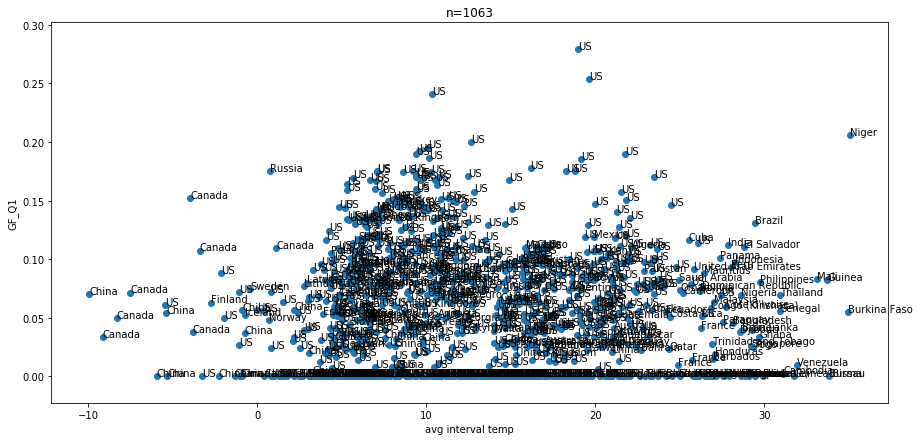

In [46]:
# hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(['Australia', 'US', 'Israel', 'France'])]\
#                                     [['Country_Region', 'GDP', 'Urbanization']]
# gdp_mean = np.nanmean(hopkins_confirmed['GDP'].loc[:,'data'].values) 
# urb_mean = np.nanmean(hopkins_confirmed['Urbanization'].loc[:,'data'].values) 

GDP_THRESHOLD = 0
URB_THRESHOLD = 0
    # MEAN   - 22914, 67
    # USA    - 62794, 82
    # ISRAEL - 41715, 92
    # FRANCE - 41463, 80

confs3 = hopkins_confirmed[hopkins_confirmed['GDP'] > GDP_THRESHOLD]\
                        [hopkins_confirmed['Urbanization'] > URB_THRESHOLD]\
                        [['Country_Region', 'avg_interval_tmp', 'avg_interval_RH',\
                          'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']].dropna()
    
print('Locations in entire dataset: {0}\n'
      'Location after thresholds: {1}'.format(len(hopkins_confirmed) / 5, len(confs3)))

conf_corrs_p3 = confs3.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p3 = conf_corrs_p3[conf_corrs_p3 != 1]
_ = conf_corrs_p3.drop_duplicates()
print('\nInetrval temp correaltion Pearson')
print(conf_corrs_p3['avg_interval_tmp'])

conf_corrs_s3 = confs3.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s3 = conf_corrs_s3[conf_corrs_s3 != 1]
_ = conf_corrs_s3.drop_duplicates()
print('\nInetrval temp correaltion Spearman')
print(conf_corrs_s3['avg_interval_tmp'])

gf_q1_3 = confs3['GF_Q1'].loc[:,'data'].values.tolist()
avg_int_tmp_3 = confs3['avg_interval_tmp'].loc[:,'data'].values.tolist()

first_7_3 = confs3['first_7'].loc[:,'data'].values
first_7_3 = np.nan_to_num(first_7_3) #, nan=np.nanmean(first_7_3))

fig, axes = plt.subplots(figsize=(15, 7))
_ = axes.scatter(avg_int_tmp_3, gf_q1_3)
n = len(confs3)

_ = axes.set_xlabel('avg interval temp')
_ = axes.set_ylabel('GF_Q1')
_ = axes.set_title('n={0}'.format(n))

countries3 = confs3['Country_Region'].loc[:,'data'].values.tolist()

for i, txt in enumerate(countries3):
    _ = axes.annotate(txt, (avg_int_tmp_3[i], gf_q1_3[i]))


Significant correlations with p-values

In [303]:
corr_3 = stats.pearsonr(gf_q1_3, avg_int_tmp_3)
print('GF_Q1 vs avg_interval_tmp correaltion Pearson: {0}, p-value: {1}'.format(corr_3[0], corr_3[1]))

corr_3 = stats.spearmanr(gf_q1_3, avg_int_tmp_3)
print('GF_Q1 vs avg_interval_tmp correaltion Spearman: {0}, p-value: {1}'.format(corr_3[0], corr_3[1]))


GF_Q1 vs avg_interval_tmp correaltion Pearson: -0.26279370436910104, p-value: 0.08114753772707378
GF_Q1 vs avg_interval_tmp correaltion Spearman: -0.25335698689075775, p-value: 0.09310004401088315


###### Linear regression

In [ ]:
a